In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(func.max(measurement.date)).scalar()

'2017-08-23'

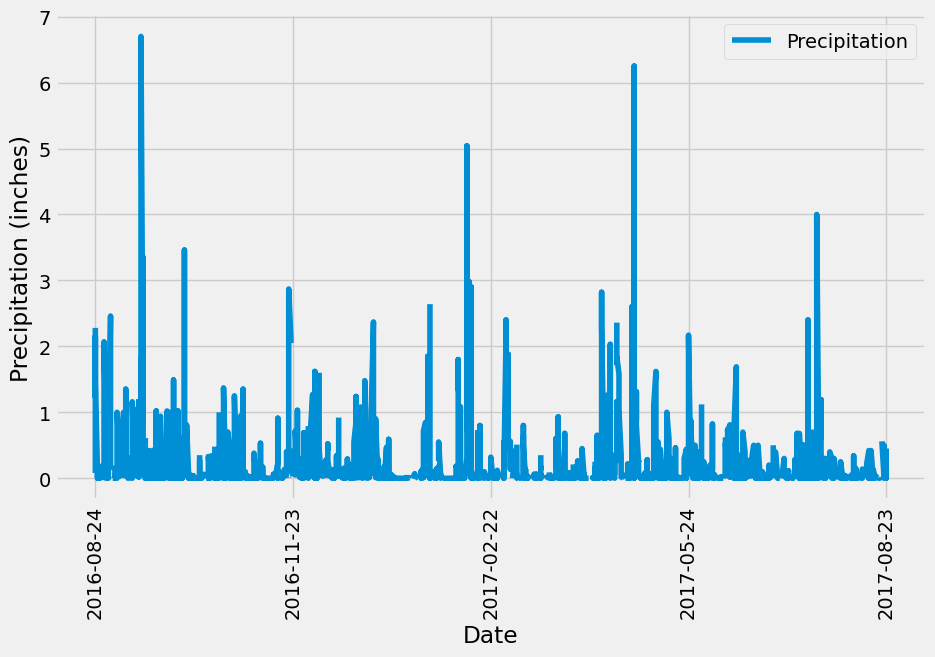

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime(most_recent_date.year - 1, most_recent_date.month, most_recent_date.day)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= one_year_ago)\
    .order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), periods=5)
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(date_range, [date.strftime('%Y-%m-%d') for date in date_range], rotation=90)
plt.legend()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).scalar()

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc())[0][0]
session.query(func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs))\
    .filter(measurement.station == most_active_station).one()

(54.0, 85.0, 71.66378066378067)

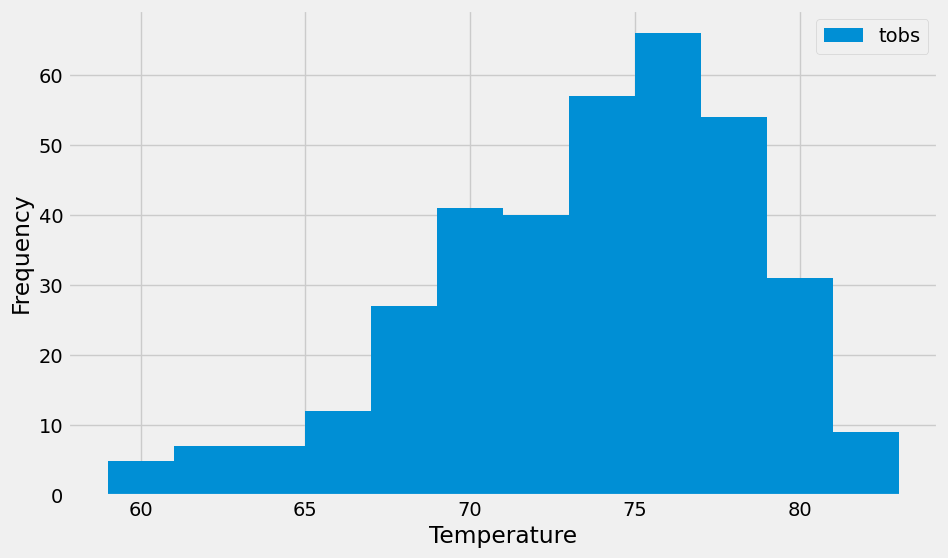

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date_str = session.query(func.max(measurement.date))\
    .filter(measurement.station == most_active_station).scalar()
latest_date = dt.datetime.strptime(latest_date_str, '%Y-%m-%d')
one_year_ago = latest_date - dt.timedelta(days=365)
temperature_data = session.query(measurement.tobs)\
    .filter(measurement.station == most_active_station)\
    .filter(measurement.date >= one_year_ago).all()
temperatures = [temp[0] for temp in temperature_data]

plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()
